## Project done by:
1. Luo Mao Yuan (U2220249K)
2. Sunkara Bhargavi (U2222578K)
3. Tey Cia Meng (U2220352B)

## Contributions:
1. Luo Mao Yuan

- Conducted in-depth research on the Deep Q-learning reinforcement learning agent
- Implementated code for the DQN model
- Presented findings and gave analysis
- Tested and debugged the code to be functional and working

2. Sunkara Bhargavi

- Conducted in-depth research on the Deep Q-learning reinforcement learning agent
- Implementated code for the DQN model
- Presented findings and gave analysis
- Tested and debugged the code to be functional and working

3. Tey Cia Meng

- Conducted in-depth research on the Deep Q-learning reinforcement learning agent
- Implementated code for the DQN model
- Presented findings and gave analysis
- Tested and debugged the code to be functional and working

# Project Description

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart. In this project, we will develop a Reinforcement Learning (RL) agent. The trained agent makes the decision to push the cart to the left or right based on the **cart position, velocity, and the pole angle, angular velocity.**


# Action Space 

The action is an ndarray with shape (1,) which can take values {0, 1} indicating pushing the cart to the left or right, respectively. Note that the velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it.

| **Num** | **Action**       |
| :------- | :--------------------- |
| **0**   | Push Cart To Right        |
| **1**   | Push Cart To Left       |

# State Space

We define observation as a state (they are used interchangeably here).  
The observation is an ndarray with shape (4,) with the values corresponding to the following positions and velocities:  






| **Observation[n]** | **Observation**       | **Min**             | **Max**           |
| :------- | :--------------------- | :------------------- | :-----------------|
| **0**   | Cart Position         | -4.8               | 4.8               |
| **1**   | Cart Velocity         | -Inf               | Inf               |
| **2**   | Pole Angle            | -0.418 rad (-24°) | 0.418 rad (24°) |
| **3**   | Pole Angular Velocity | -Inf               | Inf               |

In [37]:
%%html
<style>
    table {margin-left: 0 !important;}
    img {
    width: 600px; /* Set the width to your desired size */
    height: auto; /* Maintain aspect ratio */
    }
</style>
</style>

# Requirements

Balance pole for **>500 States Per Episode**  
Pole is stated to be balanced if:  
1) Pole Angle **at most ±12°**  
2) Cart Position **within ±2.4** (centre of cart reaching edge of display)

# Solution

### Model chosen

We chose Deep Q-Learning agent for our problem.

#### What is a Deep Q-Learning agent?
It is a reinforcement learning technique that combines Q-Learning, an algorithm for learning optimal actions in an environment, with deep neural networks. <br>
Instead of saving the Q values as a (state-action, Q-value) tuple in a table, it stores a neural network that takes the state as an input and gives the Q values for every action that can be taken from that state.
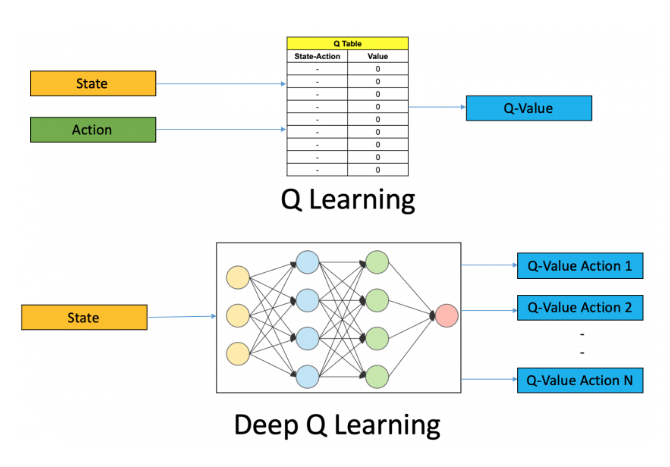
https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/

#### Why did we choose a Deep Q-Learning agent? 
We felt a deep Q-learning agent is a better choice rather than Q-learning. This is because Q-learning is not scalable. Because of infinite state space possible, storing all the possible in the gym environment (state-action, value) pairs in a table will consume a lot of space. DQL addresses this issue by using a function approximator, typically a deep neural network, to estimate Q-values.

# Installing Pytorch

Since we are utilising Deep Q Learning, PyTorch Module is required. Listed below are the instructions to setup PyTorch if it is not already installed.  


In [2]:
!pip install -r requirements.txt

# All the packages we used for this project ( also in the requirements.txt file )
# !pip install gymnasium==0.29.1
# !pip install numpy==1.24.4
# !pip install matplotlib==3.5.2
# !pip install torch==2.2.2
# !pip install moviepy==1.0.3
# !pip install pygame==2.1.3
# !pip install gymansium[classic-control]

ERROR: Could not find a version that satisfies the requirement gymansium[classic-control] (from versions: none)
ERROR: No matching distribution found for gymansium[classic-control]


# Importing Helper Functions & Dependencies

In [3]:
import gymnasium
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo
from gymnasium.utils.play import play
gymlogger.set_level(40) #error only

import numpy as np
import random 

# used for plotting graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import math
import glob # used for file path extension
import io # used for handling input output 
import base64

from IPython.display import HTML, display, clear_output

from collections import namedtuple, deque
from itertools import count

import torch as torch
import torch.nn as nn # for building and training our neural network model
import torch.optim as optim # used for optimising model parameters during training
import torch.nn.functional as F # provides access to activation functions, loss functions

# Environment Setup

In [4]:
sim_envr = gymnasium.make("CartPole-v1")

# setting up matplotlib 
plt.ion() # setting up the plots to be interactive

# use GPU if GPU is available on device, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
print(sim_envr.action_space)
print(sim_envr.observation_space.high)
print(sim_envr.observation_space.low)
print(sim_envr.reward_range)

Discrete(2)
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
(-inf, inf)


# Functions for plotting graphs of rewards

## Function for plotting the graph of the rewards and average of 100 epsidoes during training

In [6]:
# graph plotting function
def display_durations_train(show_result=False):
    plt.figure(1)
    durations_tensor = torch.tensor(train_episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Cumulative reward for each episode')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative reward')
    plt.plot(durations_tensor.numpy())
    # Taking the average of 100 episodes and plot them...for the first 99 episodes the average is taken as 0
    if len(durations_tensor) >= 100:
        averages = durations_tensor.unfold(0, 100, 1).mean(1).view(-1)
        averages = torch.cat((torch.zeros(99), averages))
        plt.plot(averages.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if not show_result:
        display(plt.gcf())
        clear_output(wait=True)
    else:
        display(plt.gcf())

## Function for plotting the graph of the rewards and average of 10 epsidoes during testing

In [7]:
# Plot cumulative rewards for 100 episodes of trained agent

def display_durations_test(show_result=False):
    plt.figure(1)
    durations_tensor = torch.tensor(test_episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Cumulative reward for each episode')
    else:
        plt.clf()
        plt.title('Running...')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative reward')
    plt.plot(durations_tensor.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_tensor) >= 10:
        averages = durations_tensor.unfold(0, 10, 1).mean(1).view(-1)
        averages = torch.cat((torch.zeros(9), averages))
        plt.plot(averages.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if not show_result:
        display(plt.gcf())
        clear_output(wait=True)
    else:
        display(plt.gcf())

# Setting Up Replay Memory

#### Replay Buffer
Replay buffer is a buffer that stores and replays experiences collected from interactions of our agent with the environment.
We sample experiences randomly from this replay buffer and a form a batch to train our agent with . This is so that the transitions in this batch are not correlated with each other. It has been shown that this greatly stabilizes and improves the DQN training procedure.

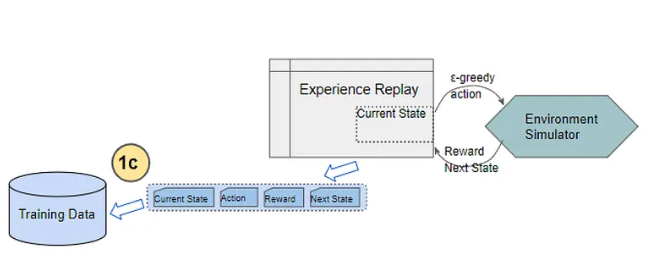

We will be using 2 classes for this.   

1. **Transition** - it is implemented as a named tuple representing a single transition in our environment. It maps the state-action pair to the next_state-reward. 

In [8]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


2. **MemoryBuffer** - it is implemented as a double-ended queue that stores these transitions. It is bounded by size and thus stores the latest transitions while removing the older ones to make space. It also has the sample method which gives us a random batch of transitions for training.

In [9]:
class MemoryBuffer(object):
    
#     Initialising the memory buffer object which is an empty double ended queue
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

#     This is to add new transitions to the buffer
    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

#         This is for selecting a random batch of transitions for training
    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

# Setting Up Q-Network

Our model will be a feed forward neural network that takes in the difference between the current and previous screen patches.  
It has two outputs, representing 
1. **Q(s,left)** which is the Q value when the agent chooses to go left 
2. **Q(s,right)** is the Q value when the agent chooses to go right

(where s is the input to the network which is the value of state).  
In effect, the network is trying to *predict the expected return of taking each action given the current input.*

In [10]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, n_actions)

    # using RELU activation function in layers
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

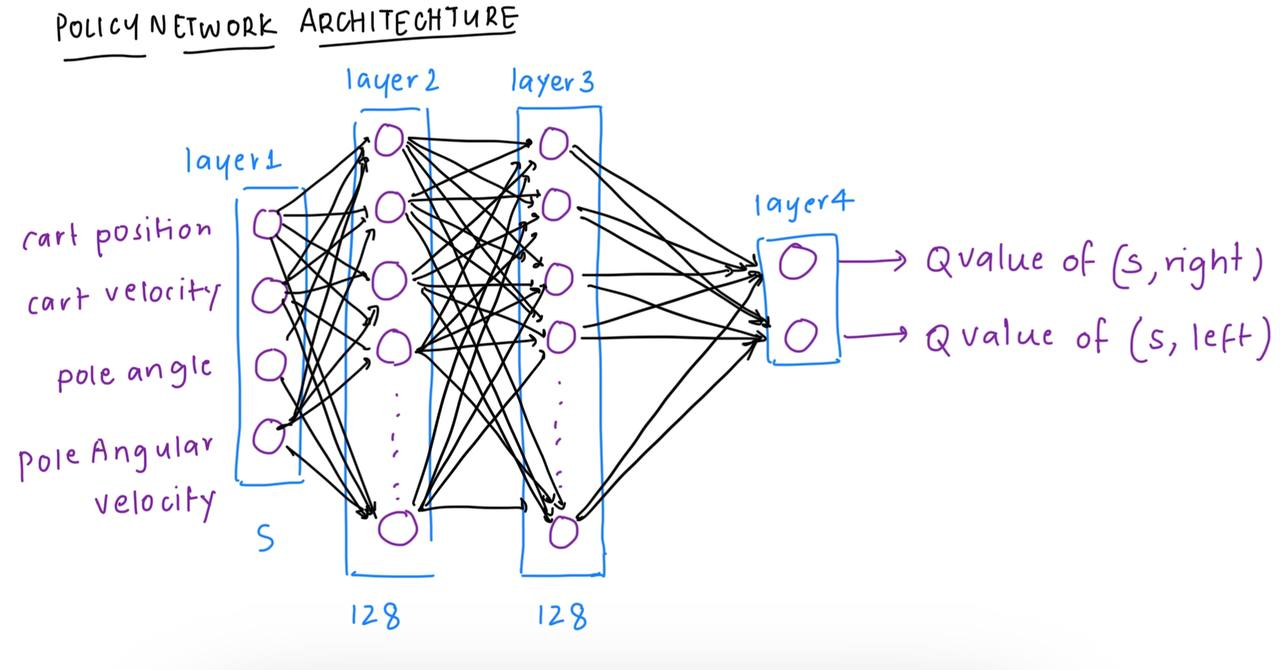

# Training The Model

#### Deep Q Learning agent network parameters 

1. **SAMPLE_SIZE** - the batch size. It is the number of transitions that are sampled from the replay buffer. 
2. **GAMMA** - this is the discount factor for future rewards in the Q-learning algorithm.
3. **INIT_EPS** - the initial value of epsilon
4. **FINAL_EPS** - the final value of epsilon
5. **EPS_DECAY_RATE** - controls the rate of exponential decay of epsilon
6. **UPDATE_RATE** - the update rate of the target network
7. **LR** - the learning rate of the neural networks ( represented by alpha in the formula )
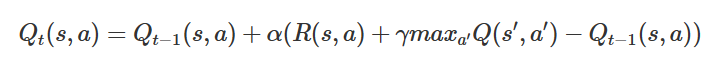
https://www.mlq.ai/deep-reinforcement-learning-q-learning/

In [11]:
# Deep Q learning agent network parameters

SAMPLE_SIZE = 128
GAMMA = 0.99
INIT_EPS = 0.95
FINAL_EPS = 0.05
EPS_DECAY_RATE = 500
UPDATE_RATE = 0.005
LR = 1e-4

In [12]:
# getting the number of actions and the size of the observation space
n_actions = sim_envr.action_space.n
n_observations = sim_envr.observation_space.shape[0]

# resetting the environment
state, _ = sim_envr.reset()

### Policy Net
This network outputs the predicted Q values for all actions for a given state. 
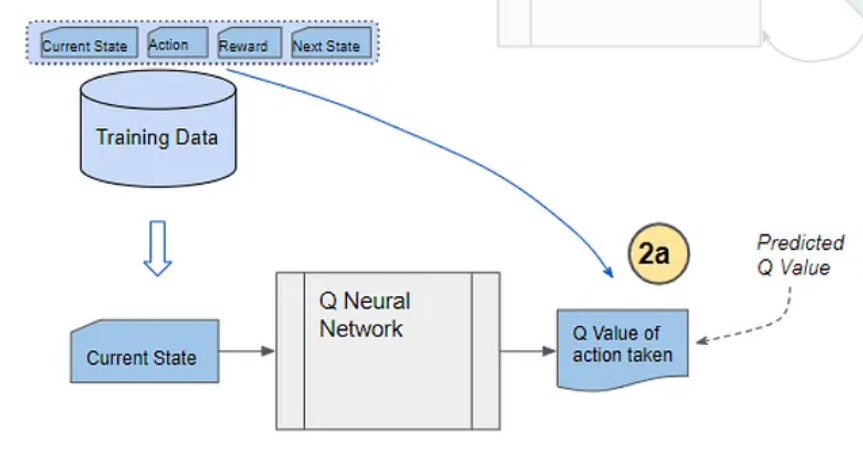

### Target Net
The target network is the ideal network. It takes the next state from each data sample and predicts the best Q value out of all actions that can be taken from that state
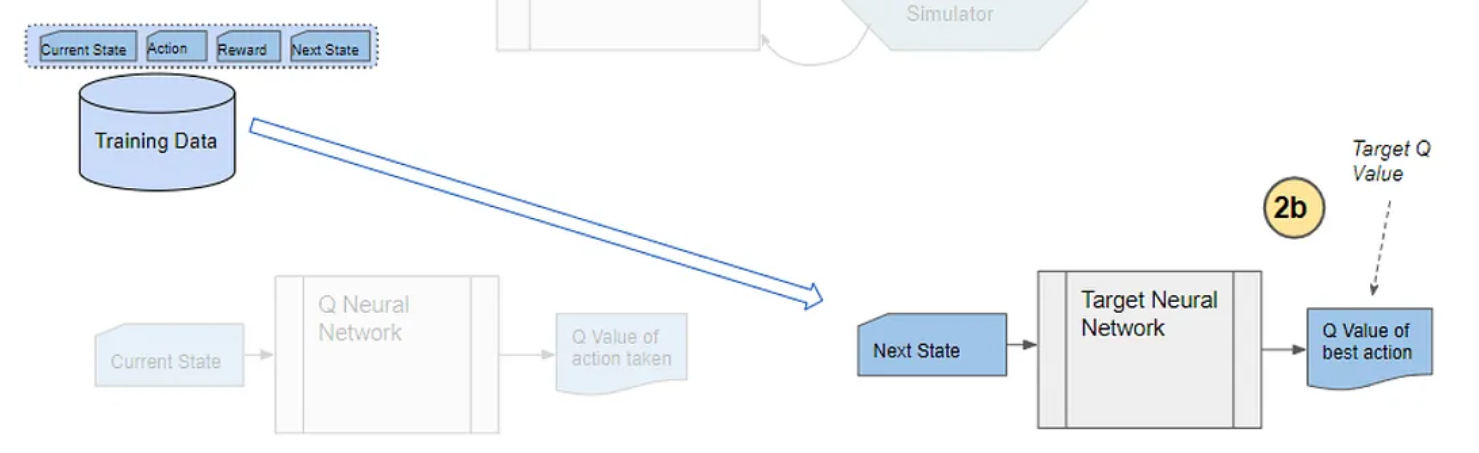

https://docs.ray.io/en/latest/rllib/rllib-replay-buffers.html<br>
https://towardsdatascience.com/reinforcement-learning-explained-visually-part-5-deep-q-networks-step-by-step-5a5317197f4b

In [13]:
# the policy and the target network has the same architechture
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = MemoryBuffer(10000)

iterations = 0

### Epsilon-Greedy 
This is a simple method to balance exploration and exploitation. It choses between exploitation and exploration through the greedy epsilon strategy.
The algorithm first chooses a random number between 0-1. If the number is greater than the epsilon value, then it will return the action that has the largest Q value (**EXPLOITATION**). If the number is less than the epsilon value, then it will return a random action (**EXPLORATION**)
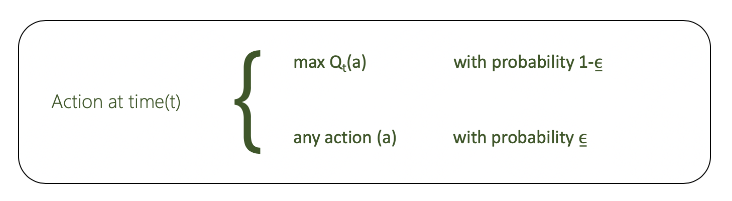
https://www.geeksforgeeks.org/epsilon-greedy-algorithm-in-reinforcement-learning/

In [14]:
def choose_action(state):
    global iterations
    sample = random.random()
    eps_threshold = FINAL_EPS + (INIT_EPS - FINAL_EPS) * math.exp(-1. * iterations / EPS_DECAY_RATE)
    iterations += 1
    if sample > eps_threshold:
        with torch.no_grad():
#       EXPLOITATION
#             returns the action that has the largest Q value if the number is greater than epsilon 
            return policy_net(state).max(1).indices.view(1, 1)
    else:
#      EXPLORATION
#         returns a random action
        return torch.tensor([[sim_envr.action_space.sample()]], device=device, dtype=torch.long)

# Stores results of each episode

# Training Loop

#### optimise_model() 

This function trains the policy network from the transitions drawn from the random sample (batch) in the replay buffer. 
It iterates through each transition in the batch - 
1. It calculates the predicted value by passing the state value as input to the policy network.
2. It calculates the actual value by adding the reward from that action with the max Q value at the next state (obtained using the target network) times the discount factor ( or gamma ). 
3. The policy network is then trained on this value.

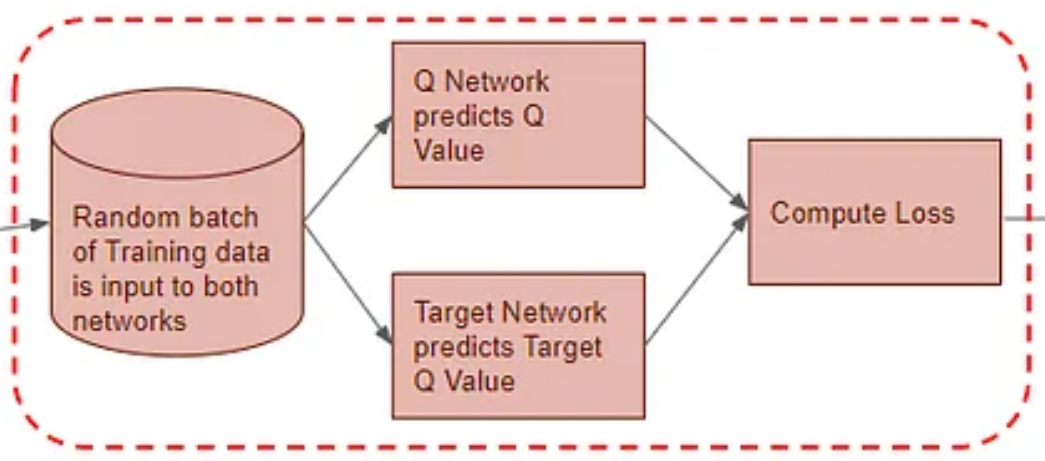

#### Loss function used during training - HUBER LOSS
We used huber loss as our loss function as it takes the advantageous characteristics of the Mean Absolute Error and Mean Squared Error loss functions and combines them into a single loss function.

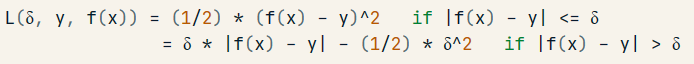

https://www.datacamp.com/tutorial/loss-function-in-machine-learning

In [15]:
# this function is to train the model on the batch of random transitions from the replay buffer

def optimize_model():
    if len(memory) < SAMPLE_SIZE:
#       if the replay buffer is not full, we won't start training
        return

#     we only start training when the replay buffer is full.
    transitions = memory.sample(SAMPLE_SIZE)
#     this converts batch-array of Transitions to transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of 
    # actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(SAMPLE_SIZE, device=device)
    
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

#### Driver Code 
This is our driver code. 
It runs all the episodes and in each epsiode -
1. Resets the state.
2. Finds the Q values of actions by passing the through the policy network.
3. Chooses action using the epsilon-greedy policy.
4. Stores the (state, action, next_state, reward) in the replay buffer. 
5. Trains the policy network model (using the optimise_model() function) if the replay buffer is full.

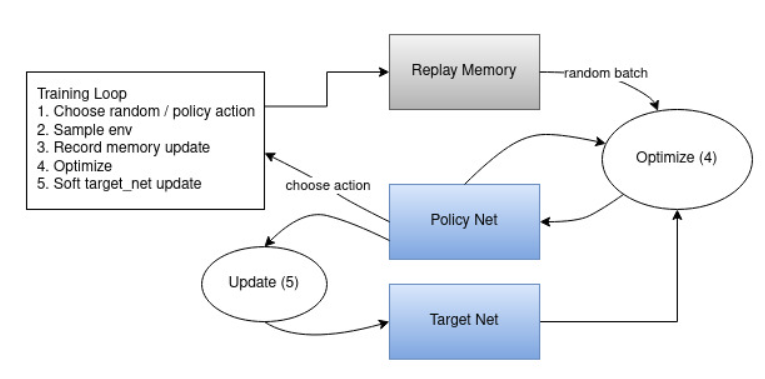

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

Complete


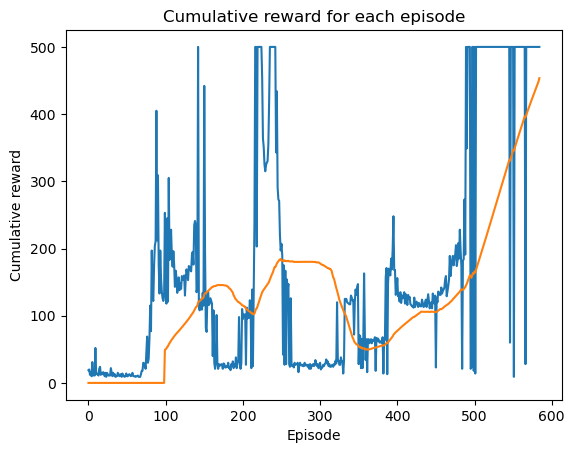

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
# Training the algorithm for 1200 epsiodes
num_of_eps = 1000
    
train_episode_durations = []
for episode_index in range(num_of_eps):
    # Initialize the environment at the start of each episode and get its state
    state, _ = sim_envr.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for timestep in count():
        action = choose_action(state) # choses the action based on the epsilon-greedy policy
        observation, reward, terminated, truncated, _ = sim_envr.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if (abs(observation[0]) > 2.4 or abs(observation[2]) > 0.209):
            done = True
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in replay buffer
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*UPDATE_RATE + target_net_state_dict[key]*(1-UPDATE_RATE)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            train_episode_durations.append(timestep + 1)
            display_durations_train()
            break
    if np.mean(train_episode_durations[-100:])>450:
        break

print('Complete')
display_durations_train(show_result=True)

# Testing Results Of Trained Model

### Saving trained model parameters into a .pth file
Trained Model Parameters will be loaded in task 2 to demonstrate the effectiveness of the RL Agent over 100 episodes.

In [17]:
torch.save(policy_net.state_dict(),"policy_net.pth")

# Task 1


### Demonstrate correctness of implementation by:

1. Sampling random state from cart pole environment  
2. Inputting state into trained agent  
3. Outputting chosen action  

In [18]:
# Obtain a sample observation space
state = sim_envr.observation_space.sample()

# Function to print out the observation space and Agent action in a readable format
def state_action(state):
    print("State Of Agent")
    print("--------------")
    print("Cart Position: ", state[0])
    print("Cart Velocity: ", state[1])
    print("Pole Angle: ", state[2], "rad", "(" + str((state[2]*180)/math.pi) + "Degrees)")
    print("Pole Angular Velocity: ", state[3])
    print("")
    print("Action Taken By Agent: ")
#     the agent will chose the action that has the maximum Q value
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action_taken = policy_net(state).max(1).indices.view(1, 1)
    if action_taken.item() == 0:
        print("Agent Moves To The Left (0)")
    elif action_taken.item() == 1:
        print("Agent Moves To The Right (1)")

state_action(state)       

State Of Agent
--------------
Cart Position:  -4.0376897
Cart Velocity:  -1.4824775e+38
Pole Angle:  0.21262401 rad (12.182458592323558Degrees)
Pole Angular Velocity:  3.9401867e+36

Action Taken By Agent: 
Agent Moves To The Left (0)


# Task 2

### Demonstrate the effectiveness of the RL Agent

1. Run 100 episodes ( Reset environment at start of each episode ) 
2. Plot cumulative reward against all episodes  
3. Print the average rewards

### Loading trained model parameters into RL Agent

We load the model parameters from the policy_net_pretrained.pth file which has the model parameters of the policy net that we had already trained before. 

In [31]:
# loading the model that we had already trained
policy_net.load_state_dict(torch.load('policy_net_pretrained.pth'))

# if you want to load the model you just trained, comment out the top line and uncomment this
# policy_net.load_state_dict(torch.load('policy_net.pth'))

<All keys matched successfully>

Since we are testing our agent, we won't be selecting the action based on the epsilon-greedy strategy, rather we chose the action that has the maximum Q value. 
We also won't be updating the policy network parameters anymore (since we are only testing).

Complete


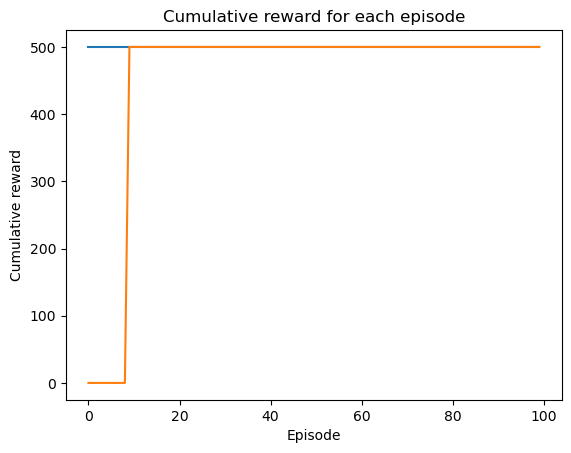

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [32]:
# Running the agent for 100 episodes
num_of_eps = 100
test_episode_durations = []
for episode_index in range(num_of_eps):
    # Initialize the environment and get its state
    state, info = sim_envr.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = policy_net(state).max(1).indices.view(1, 1) # choosing the action with maximum Q value
        observation, reward, terminated, truncated, _ = sim_envr.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if (abs(observation[0]) > 2.4 or abs(observation[2]) > 0.209):
            done = True
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Move to the next state
        state = next_state
        
        if done:
            test_episode_durations.append(t + 1)
            display_durations_test()
            break

print('Complete')
display_durations_test(show_result=True)

In [21]:
average_score = sum(test_episode_durations) / 100
print("Average cumulative reward:", average_score)
print("Is my agent good enough?", (average_score > 195))

Average cumulative reward: 500.0
Is my agent good enough? True


# Task 3

### Function for showing the video of the episode

In [22]:
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        print(mp4)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

### Render one episode played by the developed RL Agent


In [23]:
sim_envr_record = gymnasium.wrappers.RecordVideo(gymnasium.make("CartPole-v1", render_mode="rgb_array"), "./video", name_prefix = "test_video", episode_trigger=lambda x: x % 2 == 0)
total = 0
states = 0
state, info = sim_envr_record.reset()
episode_durations = []
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
sim_envr_record.start_video_recorder()
for t in count():
        action = choose_action(state)
        observation, reward, terminated, truncated, _ = sim_envr_record.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if (abs(observation[0]) > 2.4 or abs(observation[2]) > 0.209):
            done = True
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Move to the next state
        state = next_state
        
        if done:
            episode_durations.append(t + 1)
            break    

sim_envr_record.close_video_recorder()
sim_envr_record.close()

Moviepy - Building video C:\Users\bharg\Desktop\AI\Lab_1_SC3000\video\test_video-episode-0.mp4.
Moviepy - Writing video C:\Users\bharg\Desktop\AI\Lab_1_SC3000\video\test_video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\bharg\Desktop\AI\Lab_1_SC3000\video\test_video-episode-0.mp4


Moviepy - Building video C:\Users\bharg\Desktop\AI\Lab_1_SC3000\video\test_video-episode-0.mp4.
Moviepy - Writing video C:\Users\bharg\Desktop\AI\Lab_1_SC3000\video\test_video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\bharg\Desktop\AI\Lab_1_SC3000\video\test_video-episode-0.mp4


In [24]:
show_video()

video\test_video-episode-0.mp4


# References

When we were trying to comprehend the ins and outs of Deep Q Learning, we referenced two article published by *MLQ.ai* and *Analytics Vidhya* respectively, which we felt provided a comprehensive and in depth explanation to the subject.  
**Link:** https://www.mlq.ai/deep-reinforcement-learning-q-learning/  
**Link:** https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/
  
During the development of our Deep Q Agent, we consulted with an article published by *PYTORCH* which provided a detailed explanation of the implementation of the RL Agent. We were particularly inspired by their approach to the RL Agent   implementation function.  
**Link:** https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html  

Regarding the theoretical formulation aspect of Deep Q Learning, in particular the Huber Loss Function, we looked to an article published by *datacamp*, which broke down the technical aspects of the loss function into more digestable parts for  understanding.  
**Link:** https://www.datacamp.com/tutorial/loss-function-in-machine-learning

To gain a greater understanding of the epsilon greedy function, we looked to the lecture notes as well as an article published by *GeeksForGeeks* for guidance.  
**Link:** https://www.geeksforgeeks.org/epsilon-greedy-algorithm-in-reinforcement-learning/  

Lastly, to fully understand the policy & target net aspects of the Deep Q Learning algorithm, we consulted an article published by *TowardsDataScience* which gave a detailed explanation on the topic.  
**Link:** https://towardsdatascience.com/reinforcement-learning-explained-visually-part-5-deep-q-networks-step-by-step-5a5317197f4b
